In [9]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [10]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [11]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [12]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [13]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [14]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [15]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

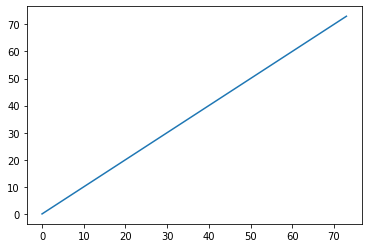

In [16]:
plt.plot(jamo_tokens)
plt.show()

In [17]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [18]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [19]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True, batch_first=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H, batch_first=True)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
#         print("Input tensor shape in Decoder: {}".format(input_tensor.shape))
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
        output_tensor = self.fc_embed(input_tensor)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        
        context_vector, alpha = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = Decoder(H, D_out).to(device)
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def train(self, input_tensor, ground_truth, loss_mask):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, batch_size, self.H).contiguous()
#         decoder_hidden = encoded_tensor[:, -1, :].transpose(0, 1)
        
        pred_tensor_list = list()
        att_weight_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).to(device)).view([batch_size, 1, -1])
        
#         print(encoded_tensor.shape)
#         print(decoder_hidden.shape)
#         print(decoder_input.shape)
        
        for i in range(ground_truth.shape[1]):
            
            pred_tensor, decoder_hidden, context_vector, att_weight = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            att_weight_list.append(att_weight)
            
#             print('pred_tensor shape: {}'.format(pred_tensor.shape))
            truth = ground_truth[:, i]
            truth = truth.type(torch.cuda.LongTensor)
            
            loss += torch.dot(loss_mask[:, i], self.criterion(pred_tensor.view([batch_size, -1]), truth)) / batch_size
            decoder_input = self.embedding_layer(truth).view([batch_size, 1, -1])
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()

        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        attention_matrix = torch.cat(att_weight_list, dim=1)
        
        return pred_tensor, attention_matrix, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [21]:
class Preloader():
    def __init__(self, mel_path_list):
        super(Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.tensor_input_list = [None] * len(mel_path_list)
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def get_batch(self):
        
        return batched_tensor, indxes 

In [22]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(preloader.sentence_length_list)
        bundle = np.stack([preloader.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
#             print(ground_truth_size_list[order])
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask
        
#         return batched_tensor, ground_truth_tensor 

In [23]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [24]:
# preloader = Preloader(mel_path_list)
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 16)

08-24 18:01:43
Calculated 100 Batches
Loss 100: 3.8131634848458424
08-24 18:01:57


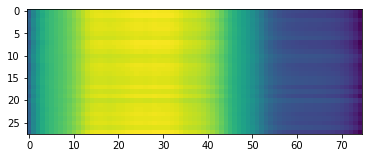

Calculated 200 Batches
Loss 200: 3.872636079788208
08-24 18:02:16


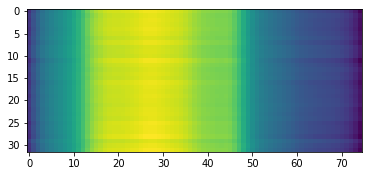

Calculated 300 Batches
Loss 300: 3.867009056939019
08-24 18:02:39


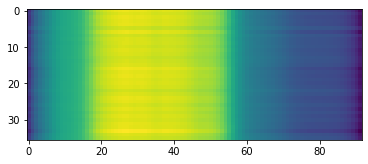

Calculated 400 Batches
Loss 400: 3.880427932739258
08-24 18:03:05


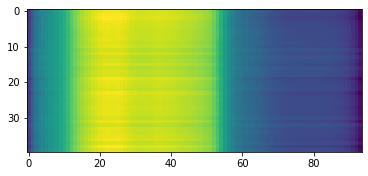

Calculated 500 Batches
Loss 500: 3.9349829933860083
08-24 18:03:33


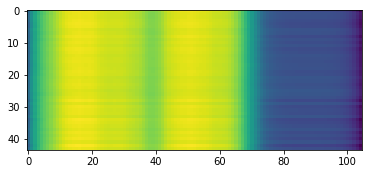

Calculated 600 Batches
Loss 600: 3.8772659301757812
08-24 18:04:03


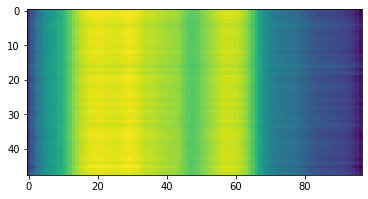

Calculated 700 Batches
Loss 700: 3.926804678780692
08-24 18:04:38


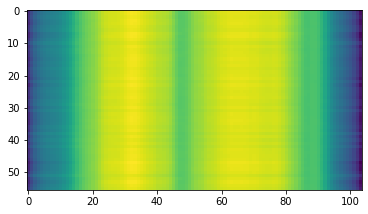

Calculated 800 Batches
Loss 800: 3.88160532171076
08-24 18:05:17


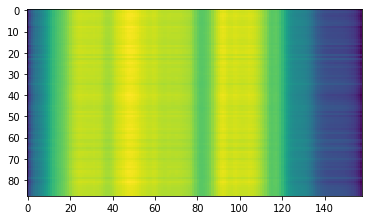

Mean Loss: 3.881243237158178
----------------------------------------------------
08-24 18:05:19
Calculated 100 Batches
Loss 100: 3.882389613560268
08-24 18:05:34


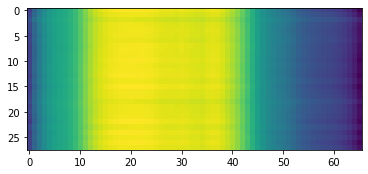

Calculated 200 Batches
Loss 200: 3.8381738662719727
08-24 18:05:53


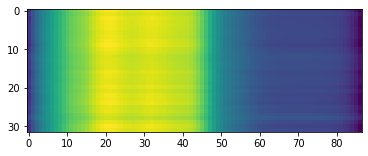

Calculated 300 Batches
Loss 300: 3.9061385260687933
08-24 18:06:15


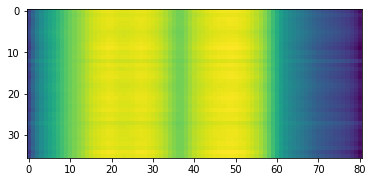

Calculated 400 Batches
Loss 400: 3.900720977783203
08-24 18:06:41


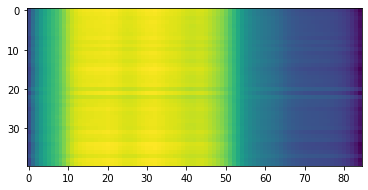

Calculated 500 Batches
Loss 500: 3.8960661454634233
08-24 18:07:09


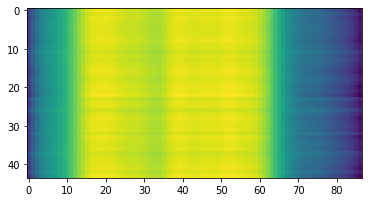

Calculated 600 Batches
Loss 600: 3.9310166041056314
08-24 18:07:40


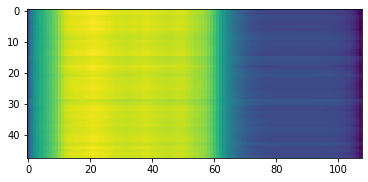

Calculated 700 Batches
Loss 700: 3.938844680786133
08-24 18:08:14


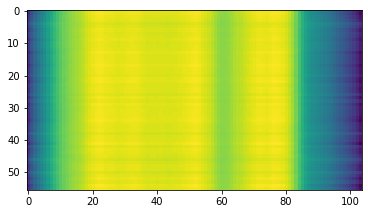

Calculated 800 Batches
Loss 800: 3.897777557373047
08-24 18:08:55


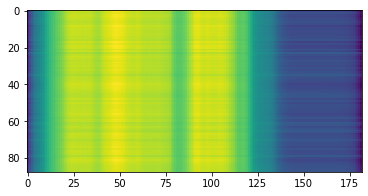

Mean Loss: 3.869840625534764
----------------------------------------------------
08-24 18:08:57
Calculated 100 Batches
Loss 100: 3.827709742954799
08-24 18:09:11


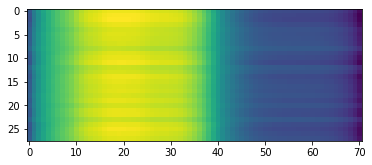

Calculated 200 Batches
Loss 200: 3.8652989864349365
08-24 18:09:30


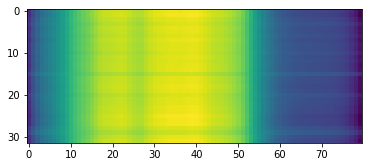

Calculated 300 Batches
Loss 300: 3.9174380832248263
08-24 18:09:53


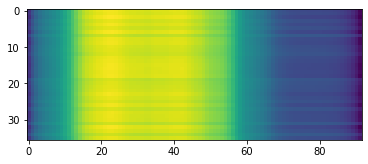

Calculated 400 Batches
Loss 400: 3.842276382446289
08-24 18:10:18


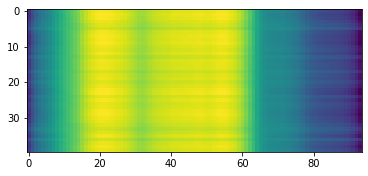

Calculated 500 Batches
Loss 500: 3.8931534507057886
08-24 18:10:47


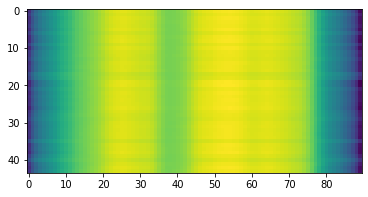

Calculated 600 Batches
Loss 600: 3.9543848037719727
08-24 18:11:18


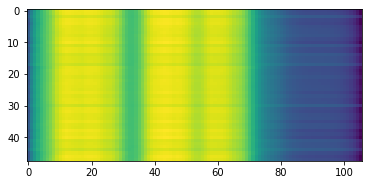

Calculated 700 Batches
Loss 700: 3.969529015677316
08-24 18:11:52


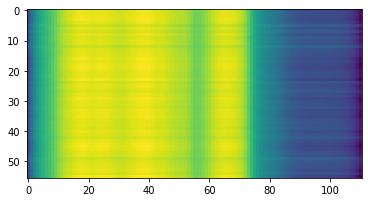

Calculated 800 Batches
Loss 800: 3.879259629683061
08-24 18:12:33


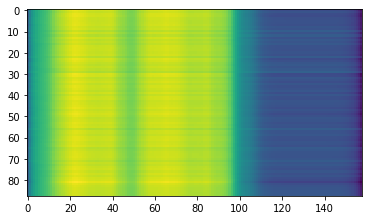

Mean Loss: 3.8685253608189427
----------------------------------------------------
08-24 18:12:34
Calculated 100 Batches
Loss 100: 3.762496675763811
08-24 18:12:49


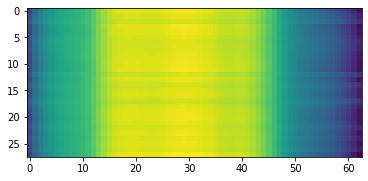

Calculated 200 Batches
Loss 200: 3.8568570613861084
08-24 18:13:08


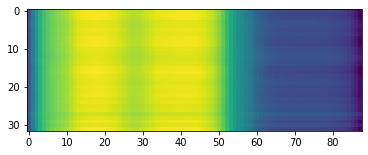

Calculated 300 Batches
Loss 300: 3.848740895589193
08-24 18:13:31


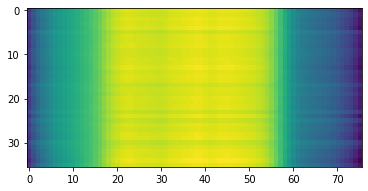

Calculated 400 Batches
Loss 400: 3.8375553131103515
08-24 18:13:56


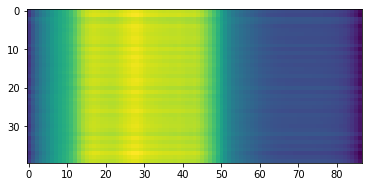

Calculated 500 Batches
Loss 500: 3.9112985784357246
08-24 18:14:24


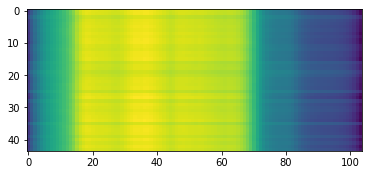

Calculated 600 Batches
Loss 600: 3.9419425328572593
08-24 18:14:55


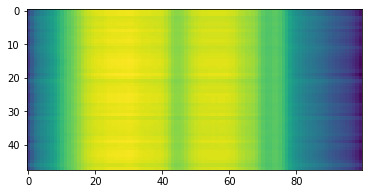

Calculated 700 Batches
Loss 700: 3.924215316772461
08-24 18:15:30


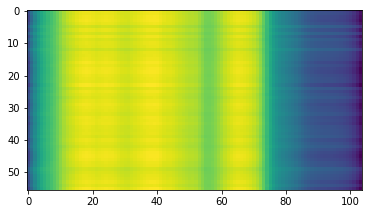

Calculated 800 Batches
Loss 800: 3.8886947631835938
08-24 18:16:11


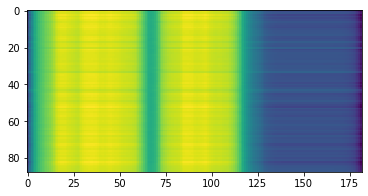

Mean Loss: 3.8680369930673995
----------------------------------------------------
08-24 18:16:13
Calculated 100 Batches
Loss 100: 3.821584701538086
08-24 18:16:27


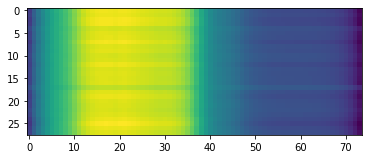

Calculated 200 Batches
Loss 200: 3.8372585773468018
08-24 18:16:46


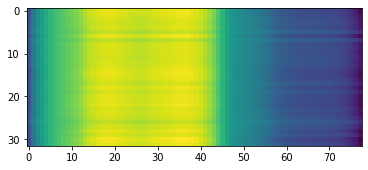

Calculated 300 Batches
Loss 300: 3.887820773654514
08-24 18:17:09


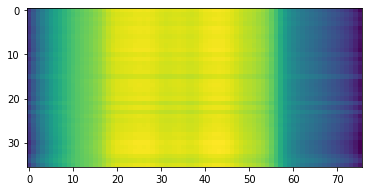

Calculated 400 Batches
Loss 400: 3.8715770721435545
08-24 18:17:35


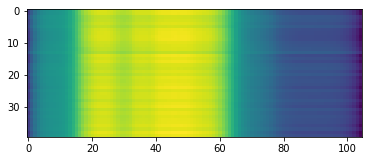

Calculated 500 Batches
Loss 500: 3.8804553638805044
08-24 18:18:03


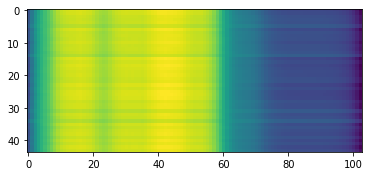

Calculated 600 Batches
Loss 600: 3.9168999989827475
08-24 18:18:35


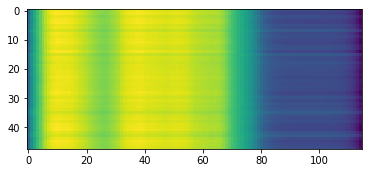

Calculated 700 Batches
Loss 700: 3.908078602382115
08-24 18:19:10


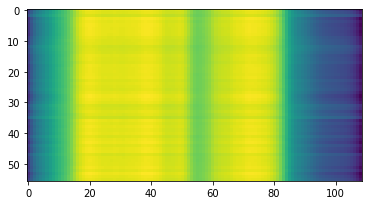

Calculated 800 Batches
Loss 800: 3.888150301846591
08-24 18:19:49


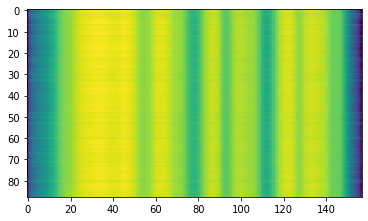

Mean Loss: 3.867588237929179
----------------------------------------------------
08-24 18:19:51
Calculated 100 Batches
Loss 100: 3.8400353022984097
08-24 18:20:06


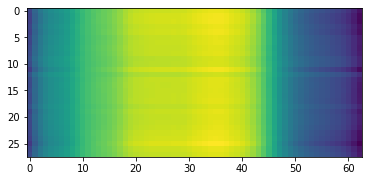

Calculated 200 Batches
Loss 200: 3.8580482006073
08-24 18:20:25


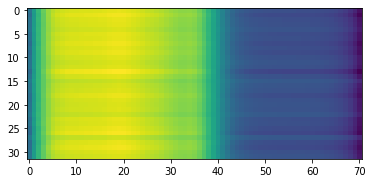

Calculated 300 Batches
Loss 300: 3.8920326232910156
08-24 18:20:48


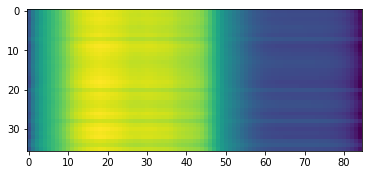

Calculated 400 Batches
Loss 400: 3.8894699096679686
08-24 18:21:14


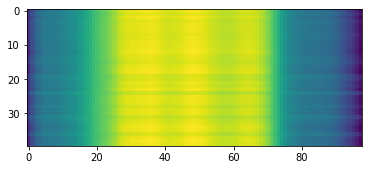

Calculated 500 Batches
Loss 500: 3.8796376315030185
08-24 18:21:43


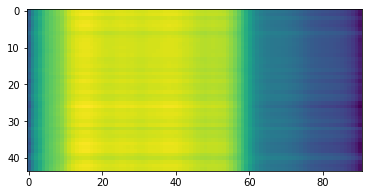

Calculated 600 Batches
Loss 600: 3.899547259012858
08-24 18:22:15


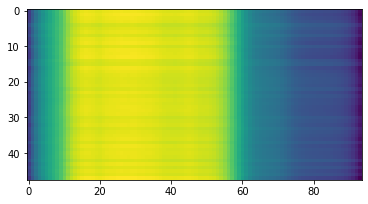

Calculated 700 Batches
Loss 700: 3.939223153250558
08-24 18:22:49


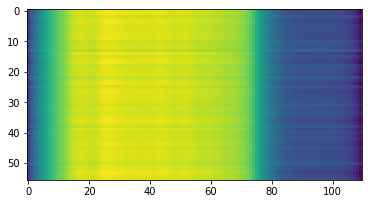

Calculated 800 Batches
Loss 800: 3.89371039650657
08-24 18:23:29


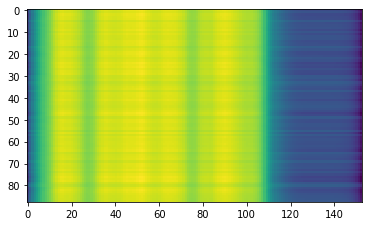

Mean Loss: 3.8672723783426535
----------------------------------------------------
08-24 18:23:31
Calculated 100 Batches
Loss 100: 3.752892630440848
08-24 18:23:45


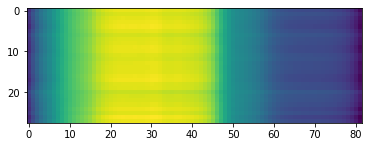

Calculated 200 Batches
Loss 200: 3.852513551712036
08-24 18:24:04


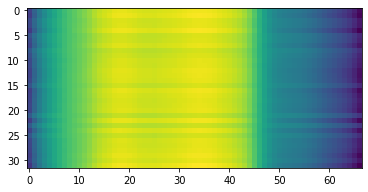

Calculated 300 Batches
Loss 300: 3.846583048502604
08-24 18:24:27


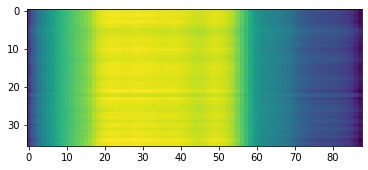

Calculated 400 Batches
Loss 400: 3.877833938598633
08-24 18:24:53


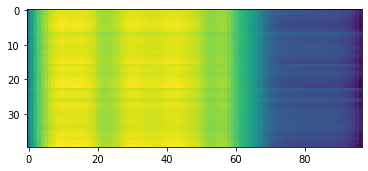

Calculated 500 Batches
Loss 500: 3.9183741482821377
08-24 18:25:22


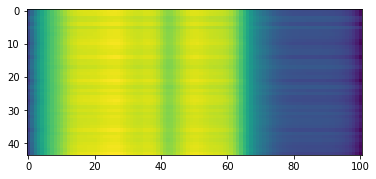

Calculated 600 Batches
Loss 600: 3.9722156524658203
08-24 18:25:53


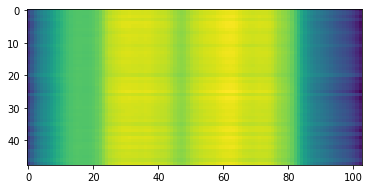

Calculated 700 Batches
Loss 700: 3.9377133505684987
08-24 18:26:28


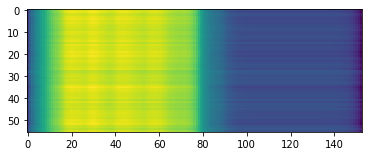

Calculated 800 Batches
Loss 800: 3.890006672252308
08-24 18:27:08


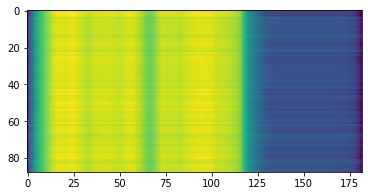

Mean Loss: 3.8673529988843063
----------------------------------------------------
08-24 18:27:10
Calculated 100 Batches
Loss 100: 3.816311700003488
08-24 18:27:24


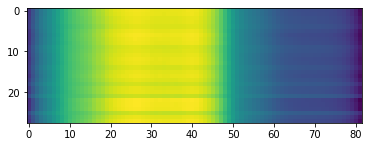

Calculated 200 Batches
Loss 200: 3.8416852951049805
08-24 18:27:43


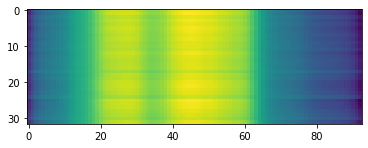

Calculated 300 Batches
Loss 300: 3.9083209567599826
08-24 18:28:06


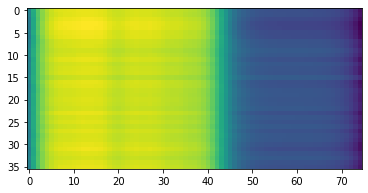

Calculated 400 Batches
Loss 400: 3.8867359161376953
08-24 18:28:32


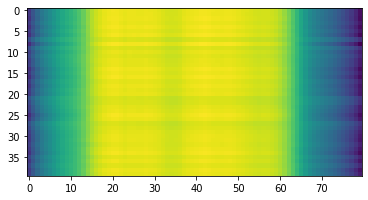

Calculated 500 Batches
Loss 500: 3.8590531782670454
08-24 18:29:01


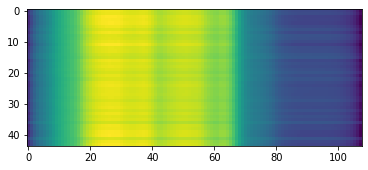

Calculated 600 Batches
Loss 600: 3.9269224802652993
08-24 18:29:32


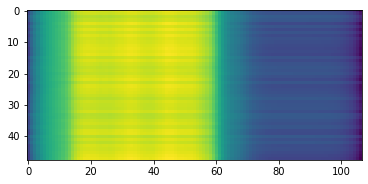

Calculated 700 Batches
Loss 700: 3.926948002406529
08-24 18:30:07


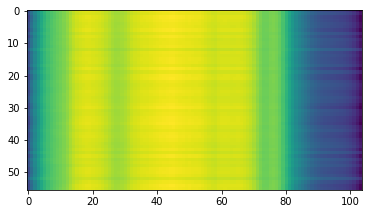

Calculated 800 Batches
Loss 800: 3.8883372220126065
08-24 18:30:47


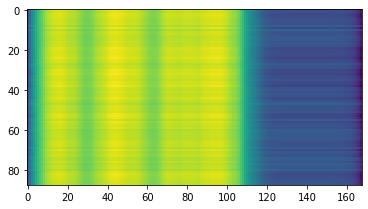

Mean Loss: 3.8645778126012096
----------------------------------------------------
08-24 18:30:49
Calculated 100 Batches
Loss 100: 3.8710744040352956
08-24 18:31:03


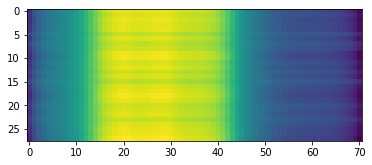

Calculated 200 Batches
Loss 200: 3.813396692276001
08-24 18:31:22


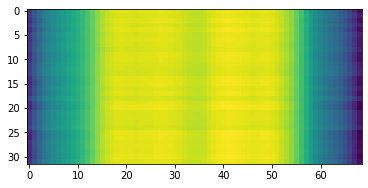

Calculated 300 Batches
Loss 300: 3.8937496609157987
08-24 18:31:45


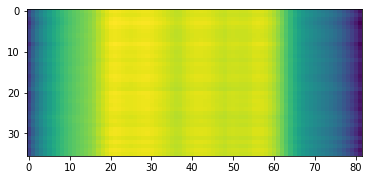

Calculated 400 Batches
Loss 400: 3.8969112396240235
08-24 18:32:11


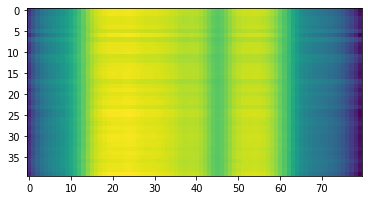

Calculated 500 Batches
Loss 500: 3.938911615416061
08-24 18:32:39


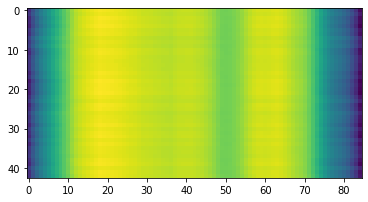

Calculated 600 Batches
Loss 600: 3.8891900380452475
08-24 18:33:11


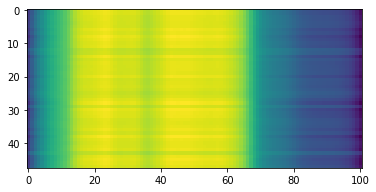

Calculated 700 Batches
Loss 700: 3.933144978114537
08-24 18:33:45


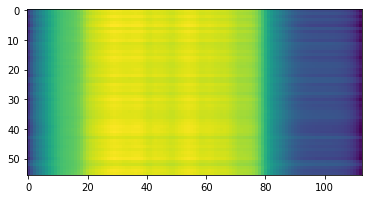

Calculated 800 Batches
Loss 800: 3.8995576338334517
08-24 18:34:24


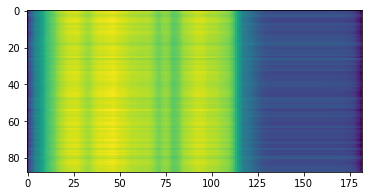

Mean Loss: 3.8662608986341955
----------------------------------------------------
08-24 18:34:26
Calculated 100 Batches
Loss 100: 3.814896719796317
08-24 18:34:40


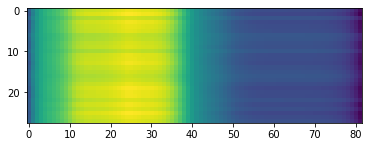

Calculated 200 Batches
Loss 200: 3.866582155227661
08-24 18:34:59


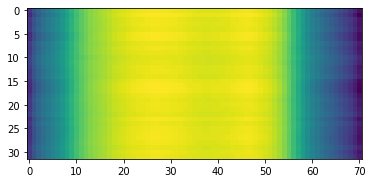

Calculated 300 Batches
Loss 300: 3.806399875217014
08-24 18:35:22


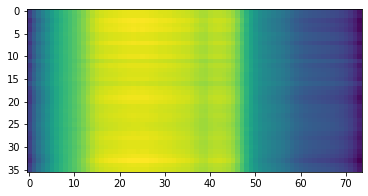

Calculated 400 Batches
Loss 400: 3.814128112792969
08-24 18:35:48


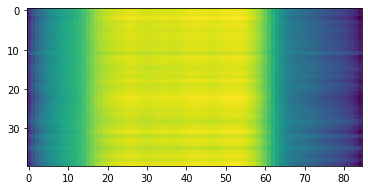

Calculated 500 Batches
Loss 500: 3.8905764493075283
08-24 18:36:16


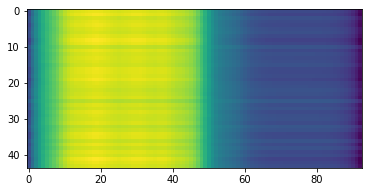

Calculated 600 Batches
Loss 600: 3.914761225382487
08-24 18:36:46


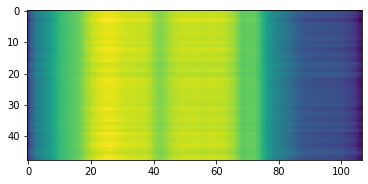

Calculated 700 Batches
Loss 700: 3.9451214926583424
08-24 18:37:20


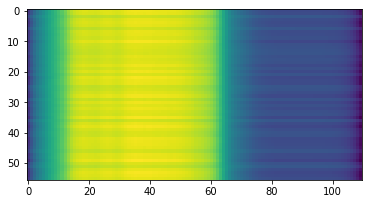

Calculated 800 Batches
Loss 800: 3.8993169611150567
08-24 18:38:00


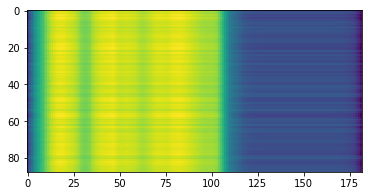

Mean Loss: 3.8648686997509105
----------------------------------------------------
08-24 18:38:01
Calculated 100 Batches
Loss 100: 3.849562508719308
08-24 18:38:16


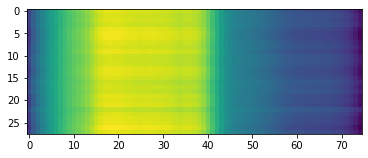

Calculated 200 Batches
Loss 200: 3.8416028022766113
08-24 18:38:35


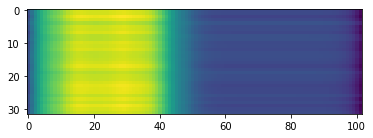

Calculated 300 Batches
Loss 300: 3.8627166748046875
08-24 18:38:58


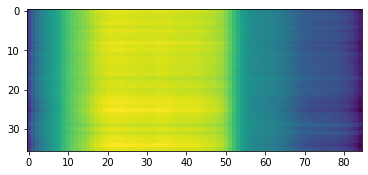

Calculated 400 Batches
Loss 400: 3.8996501922607423
08-24 18:39:24


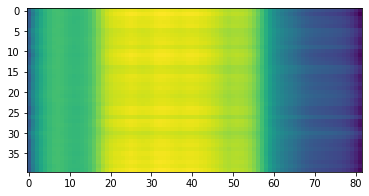

Calculated 500 Batches
Loss 500: 3.891532551158558
08-24 18:39:52


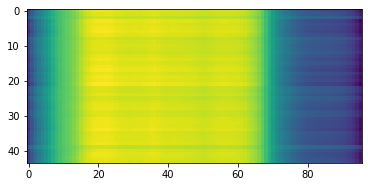

Calculated 600 Batches
Loss 600: 3.8956724802652993
08-24 18:40:23


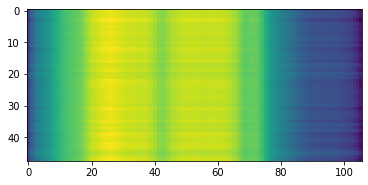

Calculated 700 Batches
Loss 700: 3.929818562098912
08-24 18:40:57


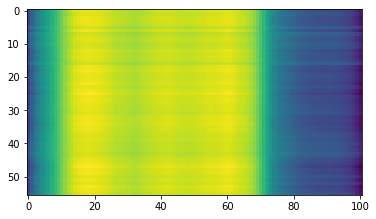

Calculated 800 Batches
Loss 800: 3.88300913030451
08-24 18:41:36


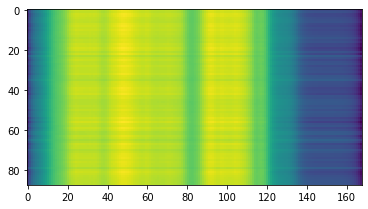

Mean Loss: 3.8648149860429526
----------------------------------------------------
08-24 18:41:38
Calculated 100 Batches
Loss 100: 3.769993100847517
08-24 18:41:52


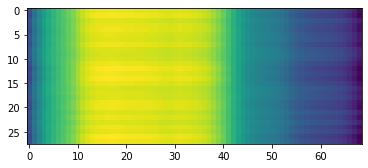

Calculated 200 Batches
Loss 200: 3.8365182876586914
08-24 18:42:11


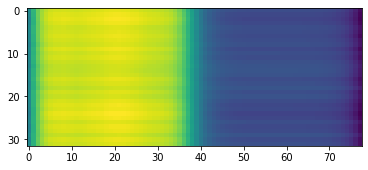

Calculated 300 Batches
Loss 300: 3.8765555487738714
08-24 18:42:34


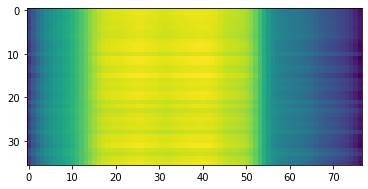

Calculated 400 Batches
Loss 400: 3.8692291259765623
08-24 18:42:59


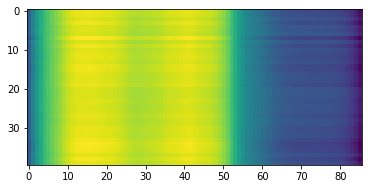

Calculated 500 Batches
Loss 500: 3.914695046164773
08-24 18:43:27


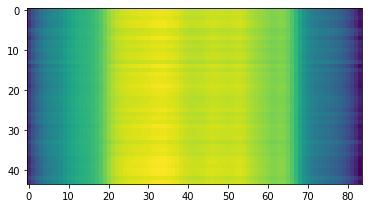

Calculated 600 Batches
Loss 600: 3.8886823654174805
08-24 18:43:58


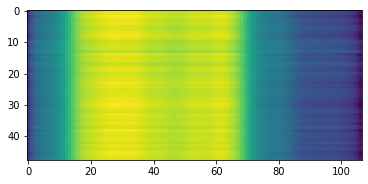

Calculated 700 Batches
Loss 700: 3.922232219151088
08-24 18:44:32


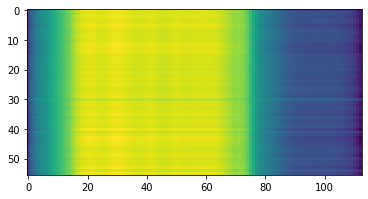

Calculated 800 Batches
Loss 800: 3.893633408979936
08-24 18:45:12


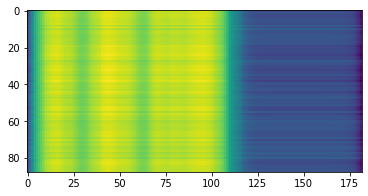

Mean Loss: 3.864518833384722
----------------------------------------------------
08-24 18:45:13
Calculated 100 Batches
Loss 100: 3.8554330553327287
08-24 18:45:28


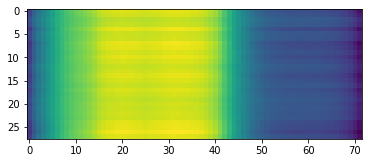

Calculated 200 Batches
Loss 200: 3.8508026599884033
08-24 18:45:47


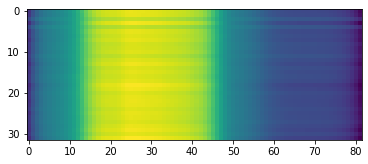

Calculated 300 Batches
Loss 300: 3.8297220865885415
08-24 18:46:09


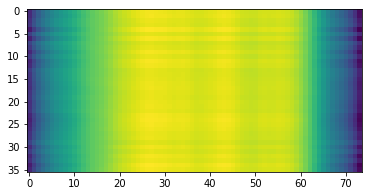

Calculated 400 Batches
Loss 400: 3.842124176025391
08-24 18:46:35


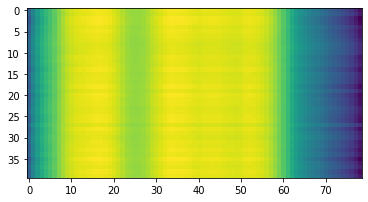

Calculated 500 Batches
Loss 500: 3.9687638716264204
08-24 18:47:03


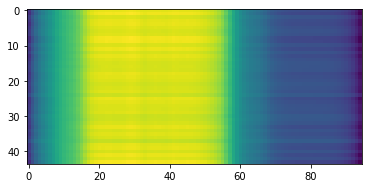

Calculated 600 Batches
Loss 600: 3.9443432490030923
08-24 18:47:35


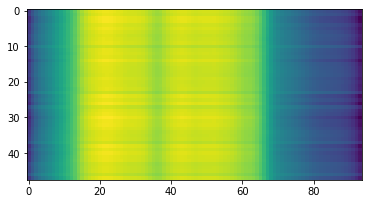

Calculated 700 Batches
Loss 700: 3.936821256365095
08-24 18:48:09


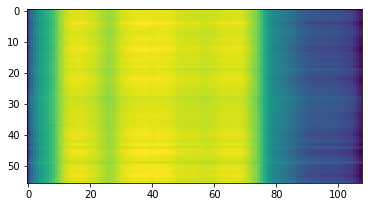

Calculated 800 Batches
Loss 800: 3.889432733709162
08-24 18:48:49


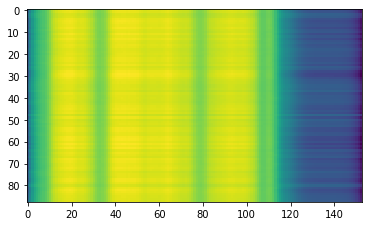

Mean Loss: 3.86416746388228
----------------------------------------------------
08-24 18:48:51
Calculated 100 Batches
Loss 100: 3.829606737409319
08-24 18:49:05


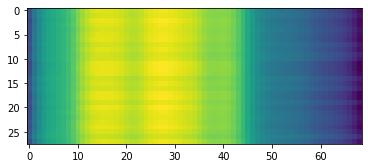

Calculated 200 Batches
Loss 200: 3.8299551010131836
08-24 18:49:24


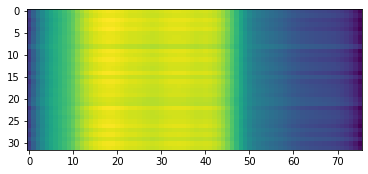

Calculated 300 Batches
Loss 300: 3.879973941379123
08-24 18:49:47


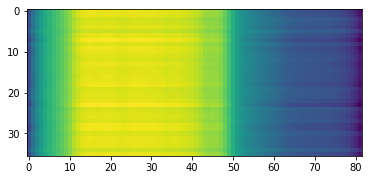

Calculated 400 Batches
Loss 400: 3.8899826049804687
08-24 18:50:13


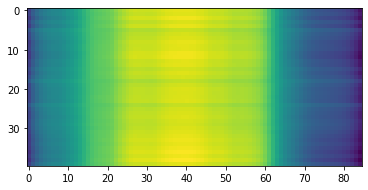

Calculated 500 Batches
Loss 500: 3.923356142911044
08-24 18:50:42


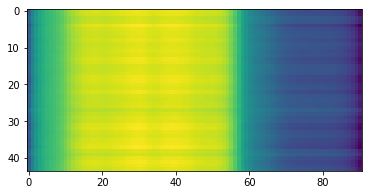

Calculated 600 Batches
Loss 600: 3.9405174255371094
08-24 18:51:13


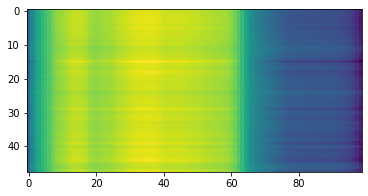

Calculated 700 Batches
Loss 700: 3.919799259730748
08-24 18:51:48


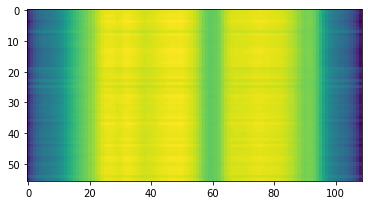

Calculated 800 Batches
Loss 800: 3.9112808921120386
08-24 18:52:29


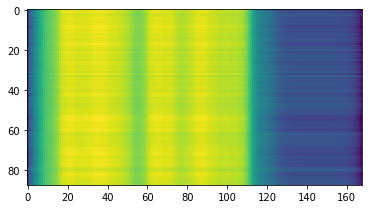

Mean Loss: 3.863768545889469
----------------------------------------------------
08-24 18:52:31
Calculated 100 Batches
Loss 100: 3.78585079738072
08-24 18:52:45


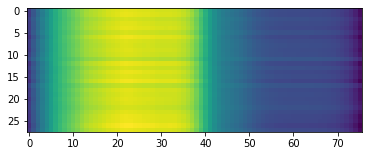

Calculated 200 Batches
Loss 200: 3.9023244380950928
08-24 18:53:04


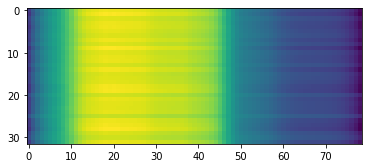

Calculated 300 Batches
Loss 300: 3.767692142062717
08-24 18:53:27


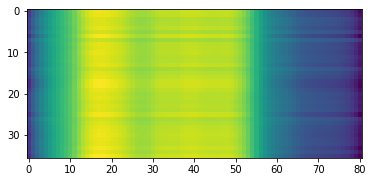

Calculated 400 Batches
Loss 400: 3.826778793334961
08-24 18:53:53


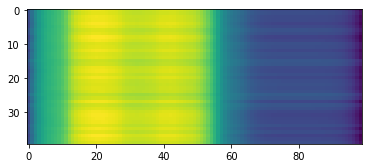

Calculated 500 Batches
Loss 500: 3.852617783979936
08-24 18:54:23


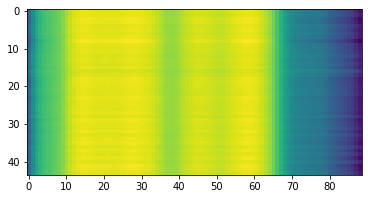

Calculated 600 Batches
Loss 600: 3.873610814412435
08-24 18:54:54


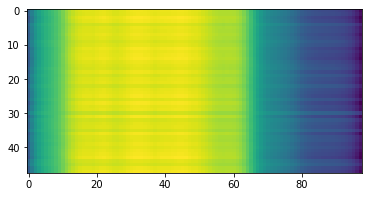

Calculated 700 Batches
Loss 700: 3.888348170689174
08-24 18:55:28


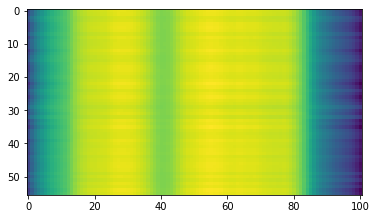

Calculated 800 Batches
Loss 800: 3.85745551369407
08-24 18:56:08


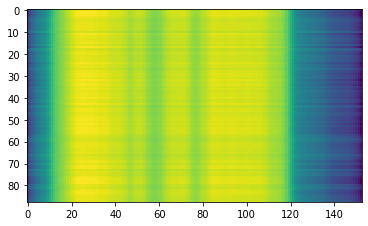

Mean Loss: 3.8641611037056562
----------------------------------------------------
08-24 18:56:10
Calculated 100 Batches
Loss 100: 3.8107248033796037
08-24 18:56:25


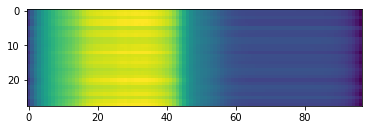

Calculated 200 Batches
Loss 200: 3.8607230186462402
08-24 18:56:44


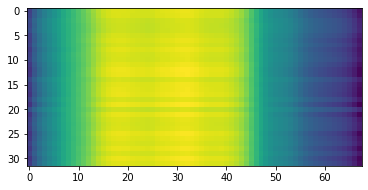

Calculated 300 Batches
Loss 300: 3.807161119249132
08-24 18:57:06


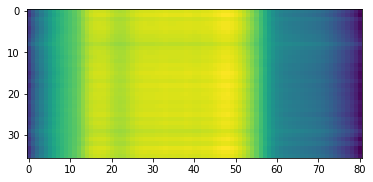

Calculated 400 Batches
Loss 400: 3.822861099243164
08-24 18:57:32


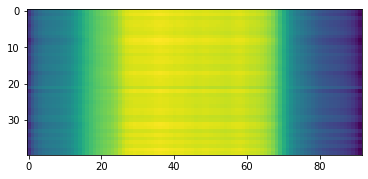

Calculated 500 Batches
Loss 500: 3.9249801635742188
08-24 18:58:01


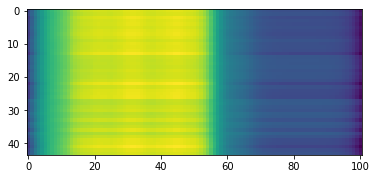

Calculated 600 Batches
Loss 600: 3.9336366653442383
08-24 18:58:32


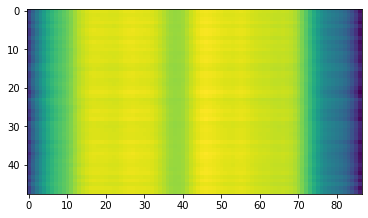

Calculated 700 Batches
Loss 700: 3.949783597673689
08-24 18:59:06


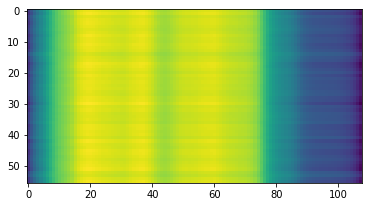

Calculated 800 Batches
Loss 800: 3.893199227072976
08-24 18:59:47


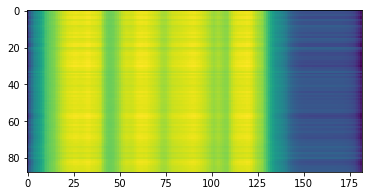

Mean Loss: 3.863756795369682
----------------------------------------------------
08-24 18:59:49
Calculated 100 Batches
Loss 100: 3.8826468331473216
08-24 19:00:03


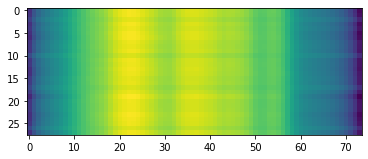

Calculated 200 Batches
Loss 200: 3.8189191818237305
08-24 19:00:22


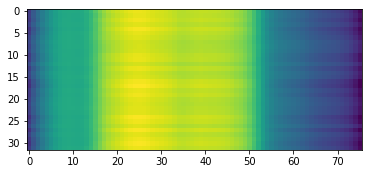

Calculated 300 Batches
Loss 300: 3.8376146952311196
08-24 19:00:45


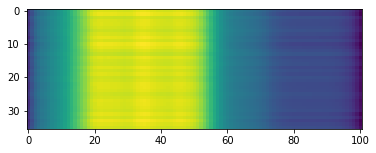

Calculated 400 Batches
Loss 400: 3.8636005401611326
08-24 19:01:11


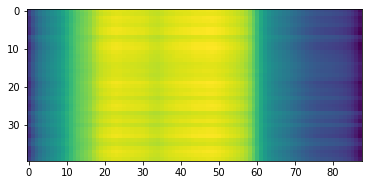

Calculated 500 Batches
Loss 500: 3.8787918090820312
08-24 19:01:40


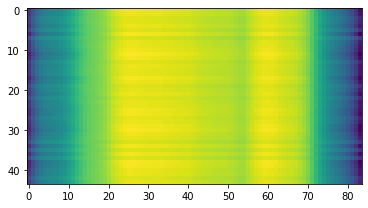

Calculated 600 Batches
Loss 600: 3.9205118815104165
08-24 19:02:11


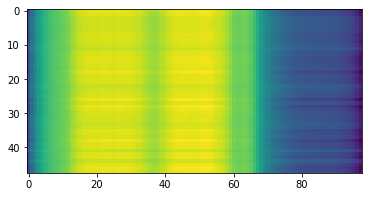

Calculated 700 Batches
Loss 700: 3.921992710658482
08-24 19:02:46


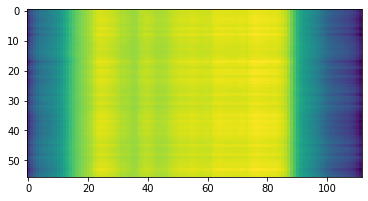

Calculated 800 Batches
Loss 800: 3.8955258456143467
08-24 19:03:27


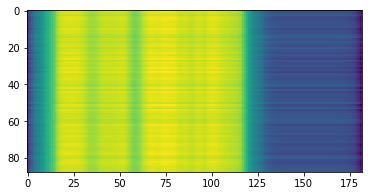

Mean Loss: 3.8633884451210303
----------------------------------------------------
08-24 19:03:28
Calculated 100 Batches
Loss 100: 3.7798124040876115
08-24 19:03:43


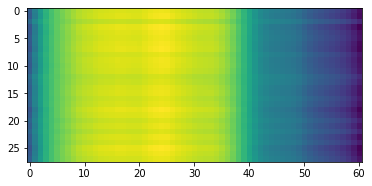

Calculated 200 Batches
Loss 200: 3.8387928009033203
08-24 19:04:02


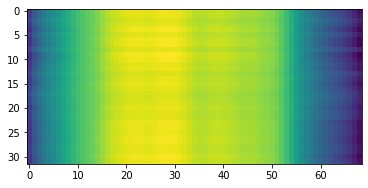

Calculated 300 Batches
Loss 300: 3.8970743815104165
08-24 19:04:24


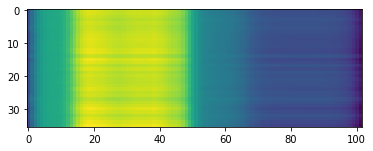

Calculated 400 Batches
Loss 400: 3.911695098876953
08-24 19:04:50


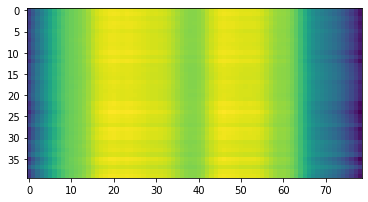

Calculated 500 Batches
Loss 500: 3.90854228626598
08-24 19:05:19


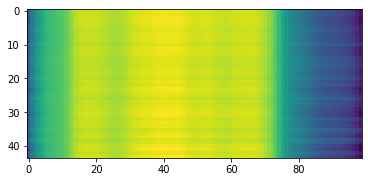

Calculated 600 Batches
Loss 600: 3.927311897277832
08-24 19:05:51


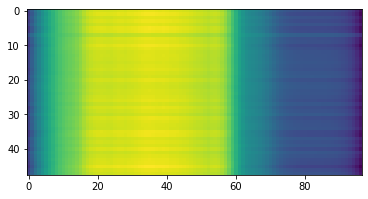

Calculated 700 Batches
Loss 700: 3.942795072283064
08-24 19:06:26


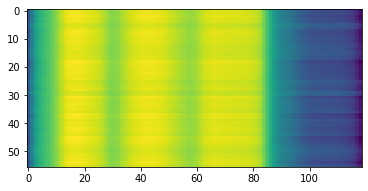

Calculated 800 Batches
Loss 800: 3.883747794411399
08-24 19:07:06


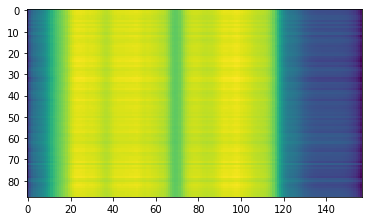

Mean Loss: 3.8628281658177634
----------------------------------------------------
08-24 19:07:08
Calculated 100 Batches
Loss 100: 3.737623759678432
08-24 19:07:22


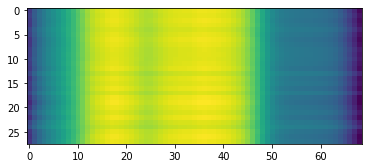

Calculated 200 Batches
Loss 200: 3.8786721229553223
08-24 19:07:41


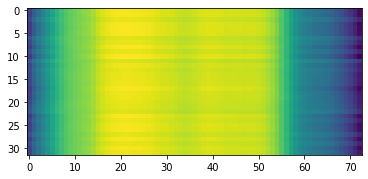

Calculated 300 Batches
Loss 300: 3.827345530192057
08-24 19:08:03


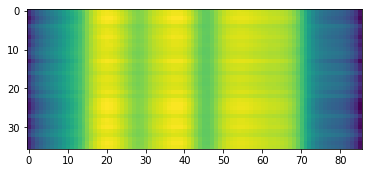

Calculated 400 Batches
Loss 400: 3.871732711791992
08-24 19:08:30


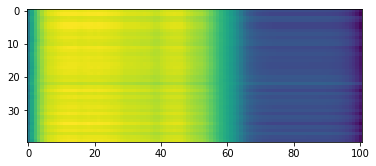

Calculated 500 Batches
Loss 500: 3.871278242631392
08-24 19:08:59


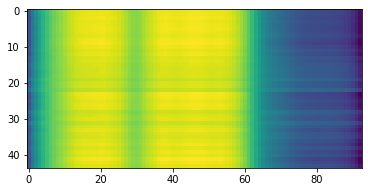

Calculated 600 Batches
Loss 600: 3.8600988388061523
08-24 19:09:32


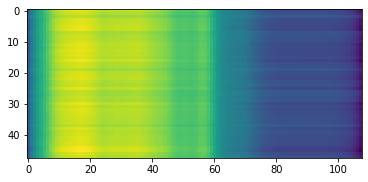

Calculated 700 Batches
Loss 700: 3.909703935895647
08-24 19:10:08


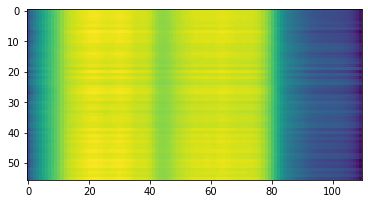

Calculated 800 Batches
Loss 800: 3.8594592701305044
08-24 19:10:48


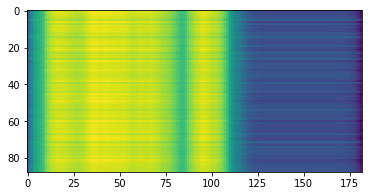

Mean Loss: 3.8536184383594856
----------------------------------------------------
08-24 19:10:50
Calculated 100 Batches
Loss 100: 3.847063882010324
08-24 19:11:04


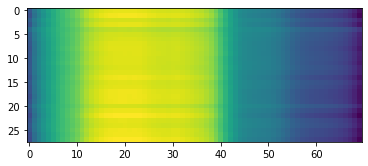

Calculated 200 Batches
Loss 200: 3.797482490539551
08-24 19:11:23


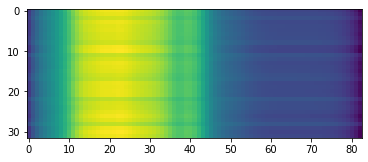

Calculated 300 Batches
Loss 300: 3.9112625122070312
08-24 19:11:46


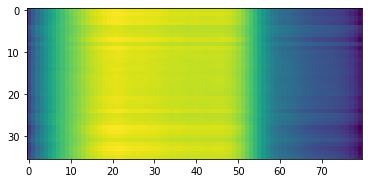

Calculated 400 Batches
Loss 400: 3.880168914794922
08-24 19:12:13


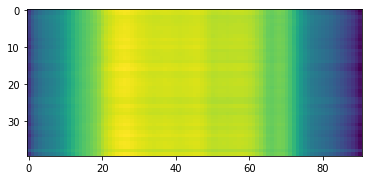

Calculated 500 Batches
Loss 500: 3.8504288413307886
08-24 19:12:43


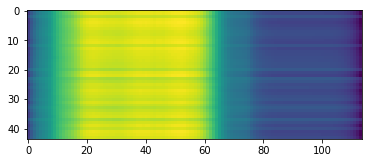

Calculated 600 Batches
Loss 600: 3.822643280029297
08-24 19:13:15


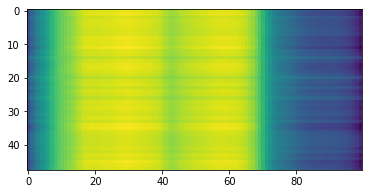

Calculated 700 Batches
Loss 700: 3.9082374572753906
08-24 19:13:50


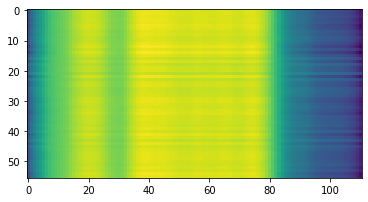

Calculated 800 Batches
Loss 800: 3.8732154152610083
08-24 19:14:30


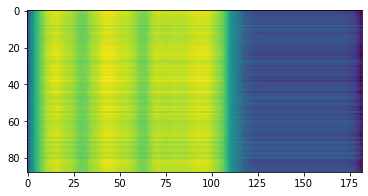

Mean Loss: 3.8502885073753244
----------------------------------------------------
08-24 19:14:32
Calculated 100 Batches
Loss 100: 3.846651349748884
08-24 19:14:46


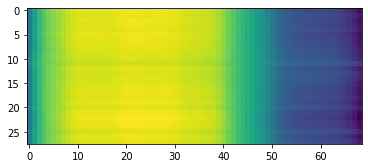

Calculated 200 Batches
Loss 200: 3.8250339031219482
08-24 19:15:05


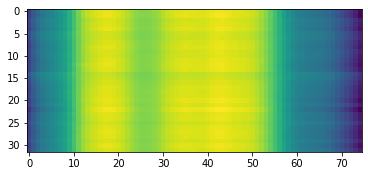

Calculated 300 Batches
Loss 300: 3.8403133816189237
08-24 19:15:27


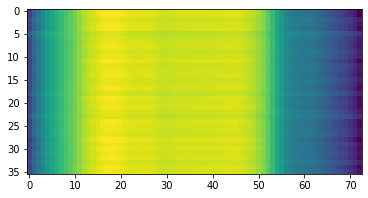

Calculated 400 Batches
Loss 400: 3.866291809082031
08-24 19:15:53


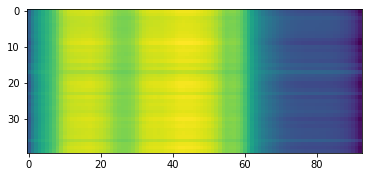

Calculated 500 Batches
Loss 500: 3.8063337152654473
08-24 19:16:21


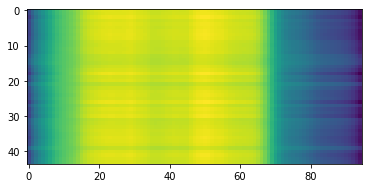

Calculated 600 Batches
Loss 600: 3.847407341003418
08-24 19:16:52


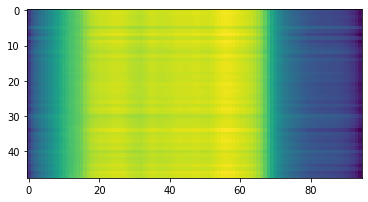

Calculated 700 Batches
Loss 700: 3.900967461722238
08-24 19:17:26


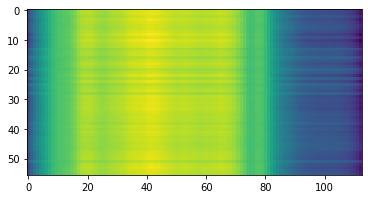

Calculated 800 Batches
Loss 800: 3.838680614124645
08-24 19:18:06


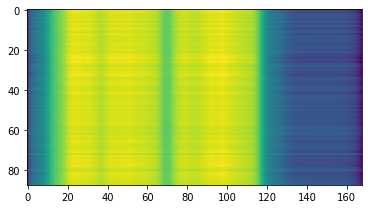

Mean Loss: 3.8485754514707775
----------------------------------------------------
08-24 19:18:08
Calculated 100 Batches
Loss 100: 3.8111490522112166
08-24 19:18:22


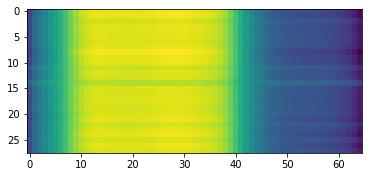

Calculated 200 Batches
Loss 200: 3.7960240840911865
08-24 19:18:41


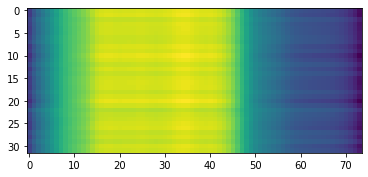

Calculated 300 Batches
Loss 300: 3.8525844150119357
08-24 19:19:04


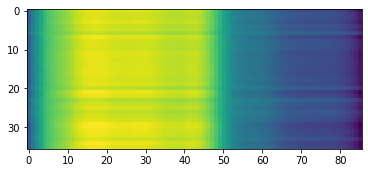

Calculated 400 Batches
Loss 400: 3.806751251220703
08-24 19:19:30


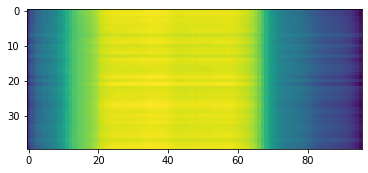

Calculated 500 Batches
Loss 500: 3.9182330044833096
08-24 19:19:59


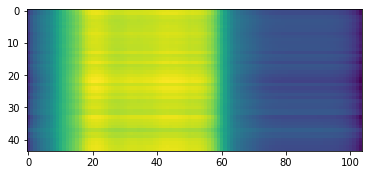

Calculated 600 Batches
Loss 600: 3.8650954564412436
08-24 19:20:29


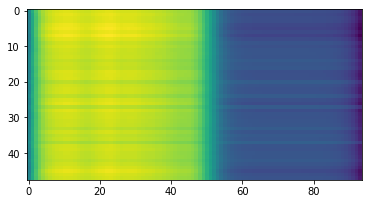

Calculated 700 Batches
Loss 700: 3.9117093767438615
08-24 19:21:03


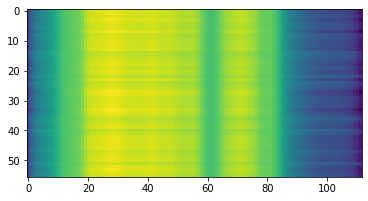

Calculated 800 Batches
Loss 800: 3.866480740633878
08-24 19:21:43


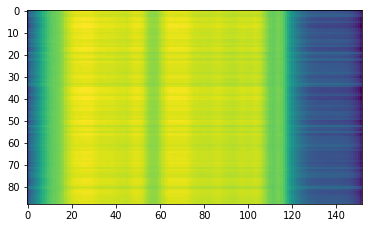

Mean Loss: 3.8485122570138883
----------------------------------------------------
08-24 19:21:45
Calculated 100 Batches
Loss 100: 3.8474668775285994
08-24 19:22:00


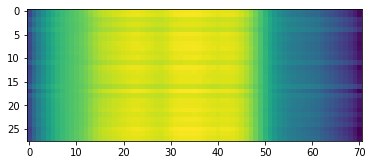

Calculated 200 Batches
Loss 200: 3.790597438812256
08-24 19:22:19


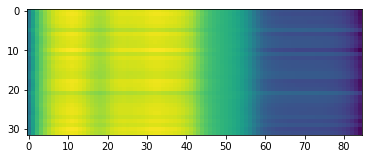

Calculated 300 Batches
Loss 300: 3.8026826646592884
08-24 19:22:41


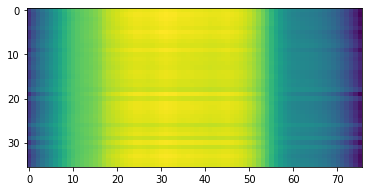

Calculated 400 Batches
Loss 400: 3.8919612884521486
08-24 19:23:06


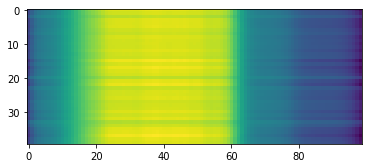

Calculated 500 Batches
Loss 500: 3.8234481811523438
08-24 19:23:34


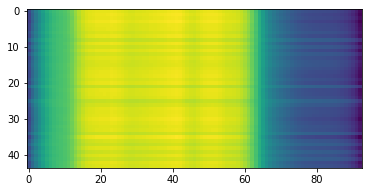

Calculated 600 Batches
Loss 600: 3.909515380859375
08-24 19:24:06


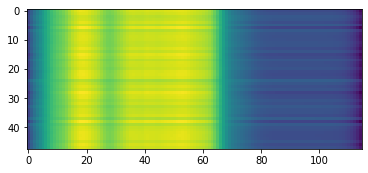

Calculated 700 Batches
Loss 700: 3.961538314819336
08-24 19:24:40


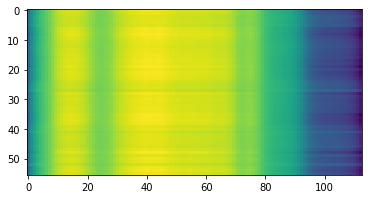

Calculated 800 Batches
Loss 800: 3.8894216364080254
08-24 19:25:21


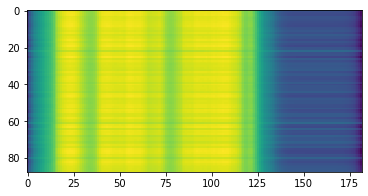

Mean Loss: 3.84744741190966
----------------------------------------------------
08-24 19:25:23
Calculated 100 Batches
Loss 100: 3.8068359919956754
08-24 19:25:37


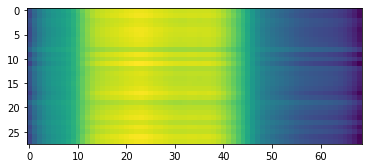

Calculated 200 Batches
Loss 200: 3.8082926273345947
08-24 19:25:56


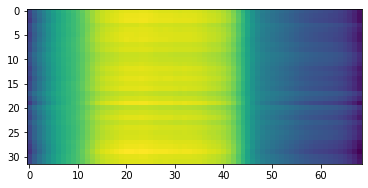

Calculated 300 Batches
Loss 300: 3.8417379591200085
08-24 19:26:18


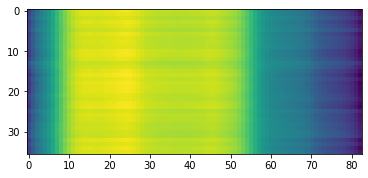

Calculated 400 Batches
Loss 400: 3.8296138763427736
08-24 19:26:44


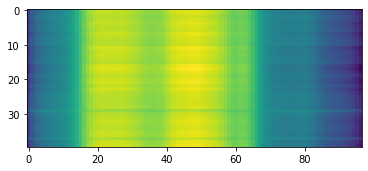

Calculated 500 Batches
Loss 500: 3.906279823996804
08-24 19:27:13


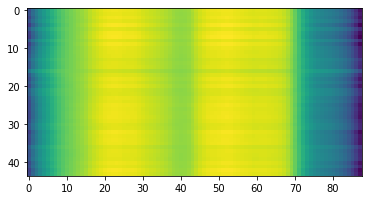

Calculated 600 Batches
Loss 600: 3.8391501108805337
08-24 19:27:44


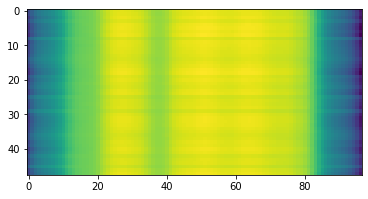

Calculated 700 Batches
Loss 700: 3.875828334263393
08-24 19:28:18


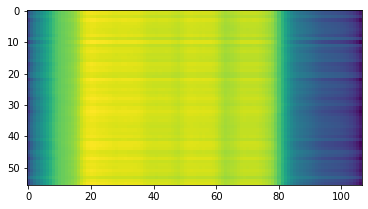

Calculated 800 Batches
Loss 800: 3.8642838217995386
08-24 19:28:59


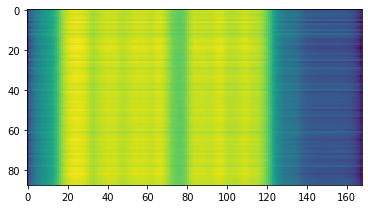

Mean Loss: 3.8482269141496146
----------------------------------------------------
08-24 19:29:01
Calculated 100 Batches
Loss 100: 3.7810352870396207
08-24 19:29:15


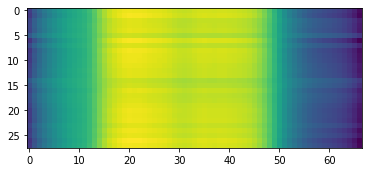

Calculated 200 Batches
Loss 200: 3.8110291957855225
08-24 19:29:34


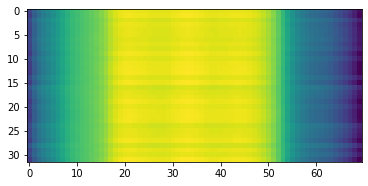

Calculated 300 Batches
Loss 300: 3.9089363945855036
08-24 19:29:57


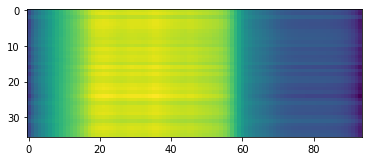

Calculated 400 Batches
Loss 400: 3.8545562744140627
08-24 19:30:23


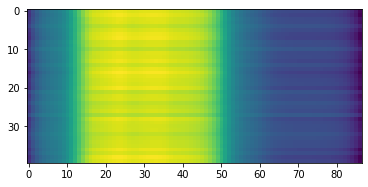

Calculated 500 Batches
Loss 500: 3.8345496437766333
08-24 19:30:51


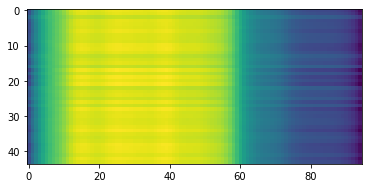

Calculated 600 Batches
Loss 600: 3.928622631316489
08-24 19:31:23


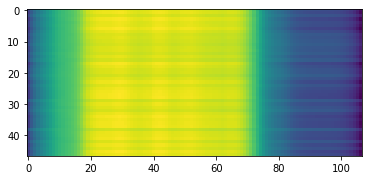

Calculated 700 Batches
Loss 700: 3.919488089425223
08-24 19:31:58


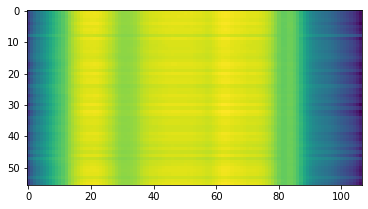

Calculated 800 Batches
Loss 800: 3.871400312943892
08-24 19:32:38


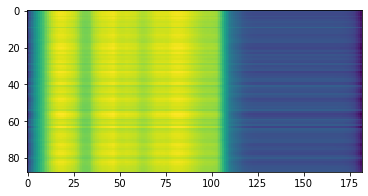

Mean Loss: 3.8473947824253103
----------------------------------------------------
08-24 19:32:40
Calculated 100 Batches
Loss 100: 3.8419137682233537
08-24 19:32:54


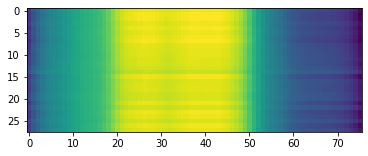

Calculated 200 Batches
Loss 200: 3.903856039047241
08-24 19:33:13


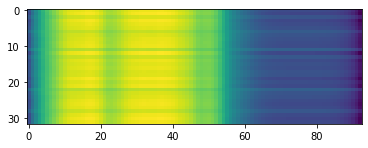

Calculated 300 Batches
Loss 300: 3.8411572774251304
08-24 19:33:36


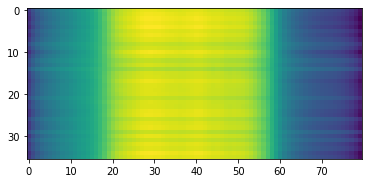

Calculated 400 Batches
Loss 400: 3.8495059967041017
08-24 19:34:01


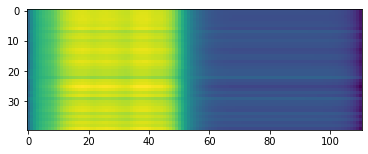

Calculated 500 Batches
Loss 500: 3.7929628545587715
08-24 19:34:30


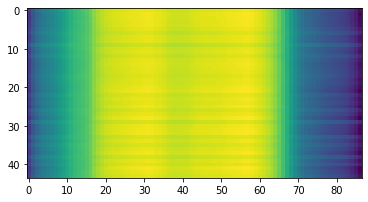

Calculated 600 Batches
Loss 600: 3.8806467056274414
08-24 19:35:01


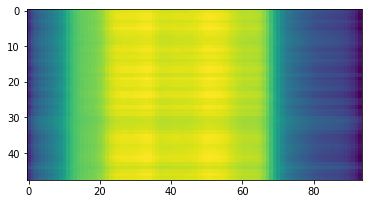

Calculated 700 Batches
Loss 700: 3.939203534807478
08-24 19:35:35


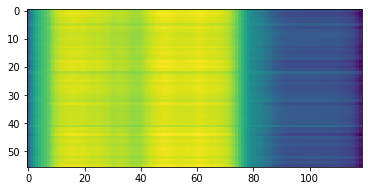

Calculated 800 Batches
Loss 800: 3.8888816833496094
08-24 19:36:15


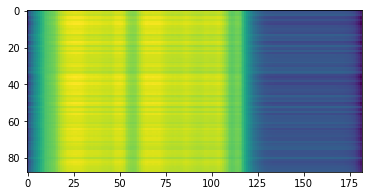

Mean Loss: 3.8465918825905216
----------------------------------------------------
08-24 19:36:17
Calculated 100 Batches
Loss 100: 3.7650206429617747
08-24 19:36:32


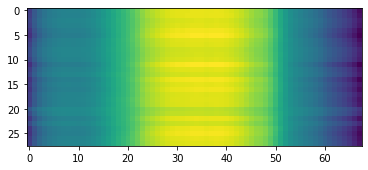

Calculated 200 Batches
Loss 200: 3.8660738468170166
08-24 19:36:51


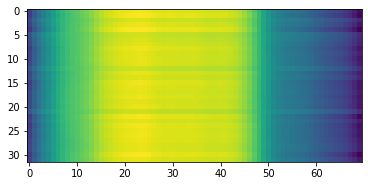

Calculated 300 Batches
Loss 300: 3.850538889567057
08-24 19:37:14


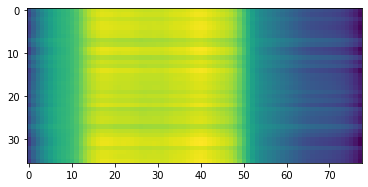

Calculated 400 Batches
Loss 400: 3.8383251190185548
08-24 19:37:40


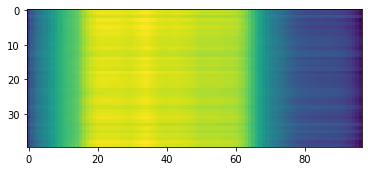

Calculated 500 Batches
Loss 500: 3.908322420987216
08-24 19:38:08


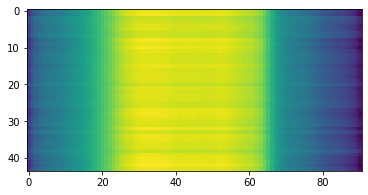

Calculated 600 Batches
Loss 600: 3.8833367029825845
08-24 19:38:40


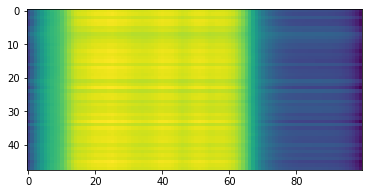

Calculated 700 Batches
Loss 700: 3.917694636753627
08-24 19:39:13


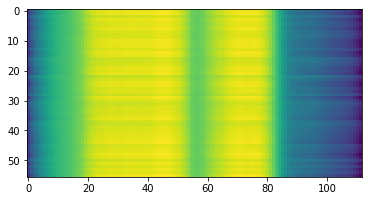

Calculated 800 Batches
Loss 800: 3.851001739501953
08-24 19:39:53


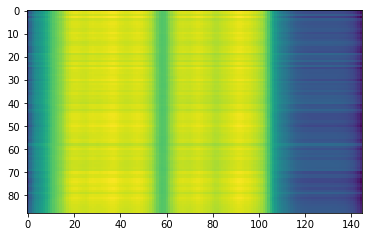

Mean Loss: 3.8463576371152404
----------------------------------------------------
08-24 19:39:55
Calculated 100 Batches
Loss 100: 3.800156729561942
08-24 19:40:09


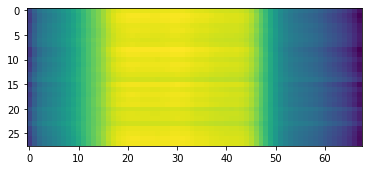

Calculated 200 Batches
Loss 200: 3.7580738067626953
08-24 19:40:28


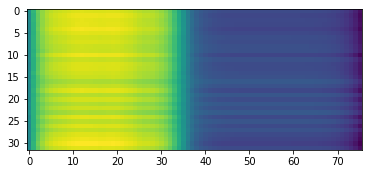

Calculated 300 Batches
Loss 300: 3.808411068386502
08-24 19:40:51


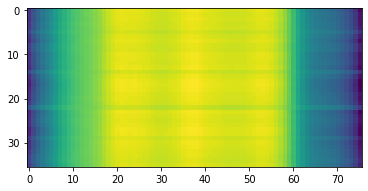

Calculated 400 Batches
Loss 400: 3.816357421875
08-24 19:41:17


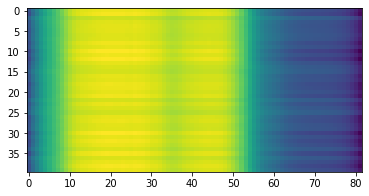

Calculated 500 Batches
Loss 500: 3.896691755814986
08-24 19:41:45


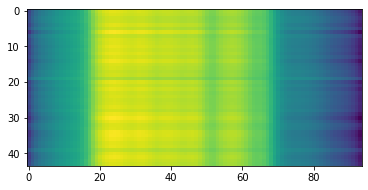

Calculated 600 Batches
Loss 600: 3.8621158599853516
08-24 19:42:16


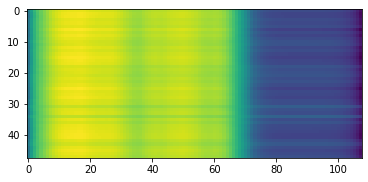

Calculated 700 Batches
Loss 700: 3.8524962833949496
08-24 19:42:50


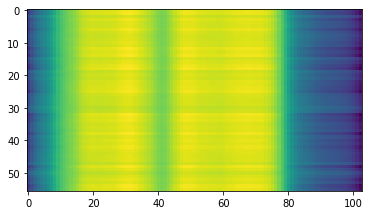

Calculated 800 Batches
Loss 800: 3.8877816633744673
08-24 19:43:30


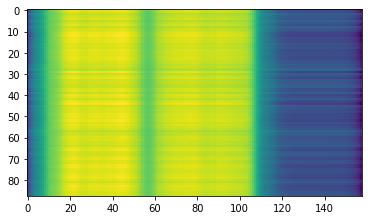

Mean Loss: 3.8464177496652465
----------------------------------------------------
08-24 19:43:32
Calculated 100 Batches
Loss 100: 3.7894050053187778
08-24 19:43:46


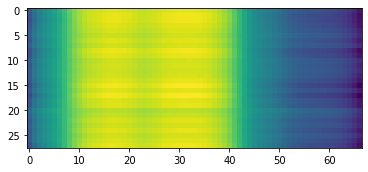

Calculated 200 Batches
Loss 200: 3.8439724445343018
08-24 19:44:05


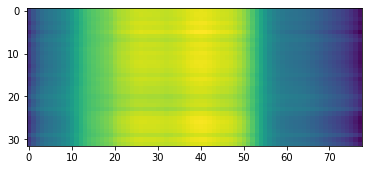

Calculated 300 Batches
Loss 300: 3.8575914171006946
08-24 19:44:28


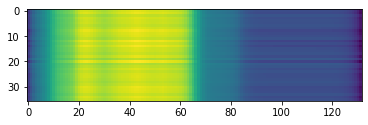

Calculated 400 Batches
Loss 400: 3.846372604370117
08-24 19:44:54


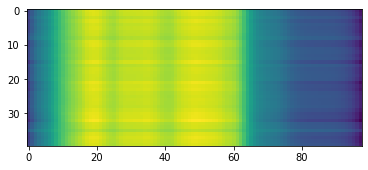

Calculated 500 Batches
Loss 500: 3.8679351806640625
08-24 19:45:23


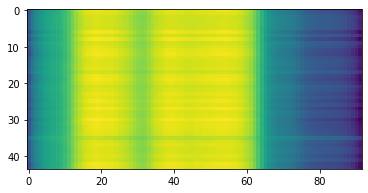

Calculated 600 Batches
Loss 600: 3.863450368245443
08-24 19:45:54


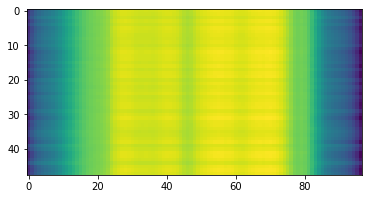

Calculated 700 Batches
Loss 700: 3.9409893580845425
08-24 19:46:28


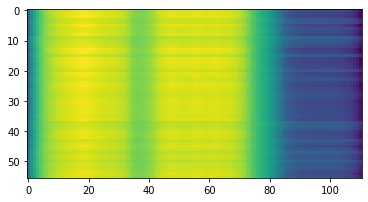

Calculated 800 Batches
Loss 800: 3.860915790904652
08-24 19:47:08


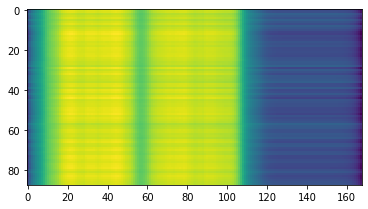

Mean Loss: 3.8469187510678773
----------------------------------------------------
08-24 19:47:09
Calculated 100 Batches
Loss 100: 3.794740676879883
08-24 19:47:24


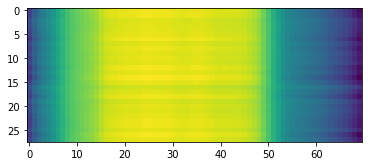

Calculated 200 Batches
Loss 200: 3.8041532039642334
08-24 19:47:43


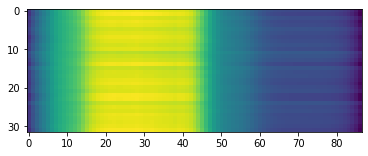

Calculated 300 Batches
Loss 300: 3.8289561801486545
08-24 19:48:05


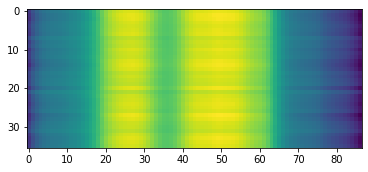

Calculated 400 Batches
Loss 400: 3.889558792114258
08-24 19:48:32


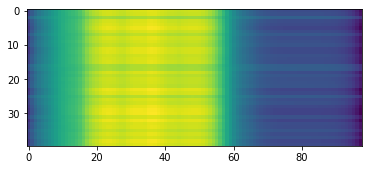

Calculated 500 Batches
Loss 500: 3.9363868019797583
08-24 19:49:00


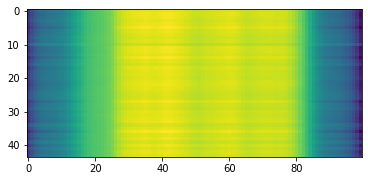

Calculated 600 Batches
Loss 600: 3.9559803009033203
08-24 19:49:31


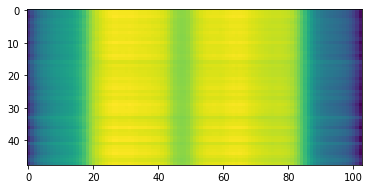

Calculated 700 Batches
Loss 700: 3.8776907239641463
08-24 19:50:07


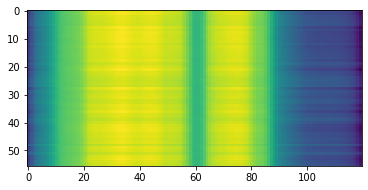

Calculated 800 Batches
Loss 800: 3.8587622209028765
08-24 19:50:47


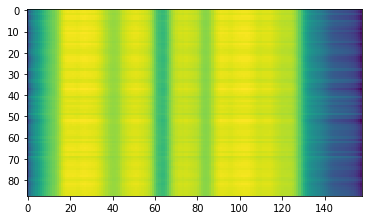

Mean Loss: 3.8463393703267665
----------------------------------------------------


In [31]:
EPOCH = 30

for epoch in range(EPOCH):
    net.load('check_point_test')
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask = preloader.get_batch()
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 100 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
#             plt.colorbar()
            plt.show()
#             _, index = pred_tensor.max(-1)
#             sentence = tokenizer.num2word(index.view(-1))
#             print(''.join(sentence))
#             print(ground_truth[0, :])
            
    net.save('check_point_test')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")

In [ ]:
EPOCH = 1

for epoch in range(EPOCH):
    
    net.load('check_point_test')
    
    for i in tqdm(range(len(metadata))):
        tensor_input = preloader.get(i)
        ground_truth = ground_truth_list[i]
        
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device))
        
        if (i % 100 == 0):
            print(datetime.datetime.now())
            print('Loss {}: {}'.format(i, loss))
            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            _, index = pred_tensor.max(-1)
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            print(metadata[i, 2])
    
    net.save('check_point_test')

In [ ]:
plt.figure()
plt.imshow(attention_matrix[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
print(attention_matrix[0, 0, :].shape)
print(sum(attention_matrix[0, 0, :]))

In [ ]:
net.save('check_point_test')

In [ ]:
net.load('check_point_test')